importing roads...
importing sites...
importing LoopHourlyFlows...
processing file: loop_detector_sites_Chesterfield.csv
processing file: loop_detector_sites_Chesterfield_all.csv
processing file: sites.xls
processing file: vdFeb14_100.csv
processing file: vdFeb14_101.csv
processing file: vdFeb14_102.csv
processing file: vdFeb14_103.csv
processing file: vdFeb14_104.csv
processing file: vdFeb14_105.csv
processing file: vdFeb14_106.csv
processing file: vdFeb14_107.csv
processing file: vdFeb14_108.csv
processing file: vdFeb14_109.csv
processing file: vdFeb14_110.csv
processing file: vdFeb14_111.csv
processing file: vdFeb14_112.csv
processing file: vdFeb14_113.csv
processing file: vdFeb14_114.csv
processing file: vdFeb14_115.csv
processing file: vdFeb14_116.csv
processing file: vdFeb14_117.csv
processing file: vdFeb14_118.csv
processing file: vdFeb14_119.csv
importing LoopDailyFlows1...
Importing LoopDailyFlows2...
Importing loopDailyFlows...
Flows and sites
Updated flows and sites
plotting

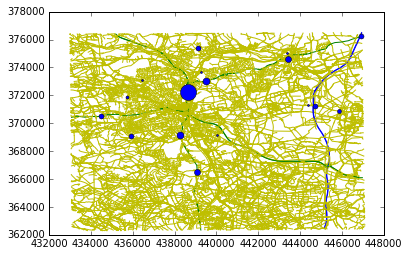

In [4]:
#before using this you need to make a link-breaked version of the roads in yoru database with the osm2pgrourting tool. 
#before use it requires a security setup: (for security reasons it wqill only run on a database which has a password setup):
#$ sudo -u postgres psql
# \password
# (enter 'postgres' for the password twice)
# Ctrl-D (to exit psql)
#Then run the link-breaking with:
#$ osm2pgrouting -f data/dcc.osm -d mydatabasename -W postgres
#you also need to do
# $ psql -d mydatabasename
#CREATE EXTENSION postgis;
# CREATE EXTENSION pgrouting;
#in psql, to enable postgres routing extension.
import psycopg2
import pandas as pd
import geopandas as gpd
import pyproj
import os,re,datetime
%matplotlib inline 
from matplotlib.pyplot import *
con = psycopg2.connect(database='mydatabasename', user='root')
cur = con.cursor()
wgs84  = pyproj.Proj(init='epsg:4326')  #WGS84
bng    = pyproj.Proj(init='epsg:27700') #british national grid
def importRoads():     #(data has come from openstreetmap, then ogr2ogr )
    print("importing roads...")
    sql = "DROP TABLE IF EXISTS Road;"
    cur.execute(sql)
    sql = "CREATE TABLE Road (name text, geom geometry, highway text);"
    cur.execute(sql)
    fn_osm_shp = "/headless/data/dcc.osm.shp/lines.shp"
    df_roads = gpd.GeoDataFrame.from_file(fn_osm_shp)
    df_roads = df_roads.to_crs({'init': 'epsg:27700'})
    for index, row in df_roads.iterrows():
        sql="INSERT INTO Road VALUES ('%s', '%s', '%s');"%(row.name, row.geometry, row.highway )
        cur.execute(sql)
    con.commit()    
def importLoopSites():
    print("importing sites...")
    sql = "DROP TABLE IF EXISTS LoopSite;"
    cur.execute(sql)
    sql = "CREATE TABLE LoopSite ( id serial PRIMARY KEY, siteID text, geom geometry);"
    cur.execute(sql)
    con.commit()    
    fn_sites = "/headless/MMFT-Class-Project-BT-Plots/LoopDetectorSitesNew/loop_detector_sites_Chesterfield.csv"
    df_sites = pd.read_csv(fn_sites, header=0)   #dataframe. header is which row to use for the field names.
    for i in range(0, df_sites.shape[0]):      #munging to extract the coordinates - the arrive in National Grid
        locationstr = str(df_sites.iloc[i]['Grid'])
        bng_east  = locationstr[0:6]
        bng_north = locationstr[6:12]
        sql = "INSERT INTO LoopSite (siteID, geom) VALUES('%s', 'POINT(%s %s)');"%(df_sites.iloc[i]['Site ID'], bng_east, bng_north )
        cur.execute(sql)
    con.commit()        
def importLoopHourlyFlows():
    print("importing LoopHourlyFlows...")
    sql = "DROP TABLE IF EXISTS LoopHourlyFlow;"
    cur.execute(sql)    
    sql = "CREATE TABLE LoopHourlyFlow ( id serial, siteIDD text, timestamp timestamp, Cosit text, LaneNumber text, \
    LaneDirection text, DirectionDescription text, Volume int, HGV int, TotalVolume int );"
    cur.execute(sql)    
    dir_detections = "/headless/MMFT-Class-Project-BT-Plots/LoopDetectorSitesNew/"
    for fn in sorted(os.listdir(dir_detections)):  #import ALL sensor files
        print("processing file: "+fn)
        m = re.match("vdFeb14_(.+).csv", fn)  #use regex to extract the sensor ID
        if m is None:  #if there was no regex match
            continue   #ignore any non detection files
        siteID = m.groups()[0]
        fn_detections = dir_detections+fn
        df_detections = pd.read_csv(fn_detections, header=0)   #dataframe. header is which row to use for the field names.
        for i in range(0, df_detections.shape[0]):   #here we use Python's DateTime library to store times properly
            datetime_text = df_detections.iloc[i] ['Sdate']
            dt = datetime.datetime.strptime(datetime_text ,  "%Y-%m-%d %H:%M:%S" ) #proper Python datetime
            df_detections['TotalVolume'] = df_detections['Volume'] + df_detections['PmlHGV']
            sql = "INSERT INTO LoopHourlyFlow (siteIDD, Cosit, timestamp, LaneNumber, LaneDirection,\
            DirectionDescription,Volume, HGV, TotalVolume ) \
            VALUES ('%s', '%s', '%s', '%s', '%s', '%s', %s, %s, %s );\
            "%(siteID, df_detections.iloc[i]['Cosit'], dt, df_detections.iloc[i]['LaneNumber'], df_detections.iloc[i]['LaneDirection'],\
            df_detections.iloc[i]['DirectionDescription'], df_detections.iloc[i]['Volume'], \
            df_detections.iloc[i]['PmlHGV'], df_detections.iloc[i]['TotalVolume'] )
            cur.execute(sql)
    con.commit() 
def ImportLoopDailyFlows1():
    print("importing LoopDailyFlows1...")
    sql = "DROP TABLE IF EXISTS LoopDailyFlow1;"
    cur.execute(sql)    
    sql = "CREATE TABLE LoopDailyFlow1 (idd serial, \
    DailyVolume int, DailyHGVs int, DailyTotalVolume int);"
    cur.execute(sql)    
    sql = "INSERT INTO LoopDailyFlow1 (DailyVolume, DailyHGVs, DailyTotalVolume)\
    SELECT SUM(Volume), SUM(HGV), SUM(TotalVolume)\
    FROM LoopHourlyFlow GROUP BY siteIDD ORDER BY siteIDD;"
    cur.execute(sql)  
con.commit() 
def ImportLoopDailyFlows2():
    print("Importing LoopDailyFlows2...")
    sql = "DROP TABLE IF EXISTS LoopDailyFlow2;"
    cur.execute(sql)   
    sql = "CREATE TABLE LoopDailyFlow2 (ida serial, siteIDD text);"
    cur.execute(sql) 
    sql = "INSERT INTO LoopDailyFlow2 (siteIDD) \
    SELECT DISTINCT siteIDD FROM LoopHourlyFlow \
    ORDER BY siteIDD;"
    cur.execute(sql)    
con.commit() 
def ImportLoopDailyFlows():
    print("Importing loopDailyFlows...")
    sql = "DROP TABLE IF EXISTS LoopDailyFlow;"
    cur.execute(sql)
    sql = "CREATE TABLE loopdailyflow AS SELECT * FROM LoopDailyFlow2 \
    JOIN LoopDailyFlow1 ON LoopDailyFlow2.ida=LoopDailyFlow1.idd;"
    cur.execute(sql)     
con.commit() 
def FlowSite1():
    print("Flows and sites")
    sql="DROP TABLE IF EXISTS new1;"
    cur.execute(sql)
    sql="CREATE TABLE new1 AS SELECT * FROM loopsite INNER JOIN loopdailyflow ON loopsite.id=loopdailyflow.idd;"
    cur.execute(sql)
con.commit()  
def FlowSite():
    print("Updated flows and sites")
    sql="DROP TABLE IF EXISTS new;"
    cur.execute(sql)
    sql="SELECT * INTO new FROM new1 WHERE NOT siteid='353' AND NOT siteid='424' AND NOT siteid='37';"
    cur.execute(sql)
con.commit()
def plotRoads():   
    print("plotting roads...")
    sql = "SELECT * FROM Road;"
    df_roads = gpd.GeoDataFrame.from_postgis(sql,con,geom_col='geom') #
    for index, row in df_roads.iterrows():
        (xs,ys) = row['geom'].coords.xy
        color='y'
        #road colour by type
        if row['highway']=="motorway":
            color = 'b'
        if row['highway']=="trunk":
            color = 'g'
        #if not color=='y':  #only plot major roads
        plot(xs, ys, color)
def plotLoopSites():    
    sql = "SELECT siteID, geom, dailytotalvolume FROM new;"
    df_sites = gpd.GeoDataFrame.from_postgis(sql,con,geom_col='geom')
    print(df_sites)#
    for index, row in df_sites.iterrows():
        (xs,ys) = row['geom'].coords.xy
        s = int(row['dailytotalvolume']/3000)
        plot(xs, ys, 'bo', markersize=s)
importRoads()
importLoopSites()
importLoopHourlyFlows()
ImportLoopDailyFlows1()
ImportLoopDailyFlows2()
ImportLoopDailyFlows()
FlowSite1()
FlowSite()
plotRoads()  
plotLoopSites()